In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 2.1

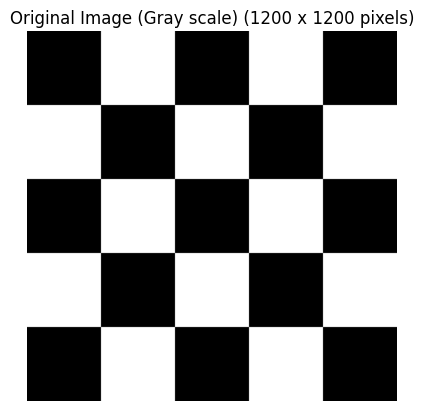

In [ ]:
# Load the image using matplotlib
image_path = 'Checkerboard_pattern.png'
image = Image.open(image_path).convert('L') #converting image to greyscale
image_array = np.array(image)
    
plt.imshow(image, cmap='gray')
plt.title('Original Image (Gray scale) (1200 x 1200 pixels)')
plt.axis('off')
plt.show()

# 2.2

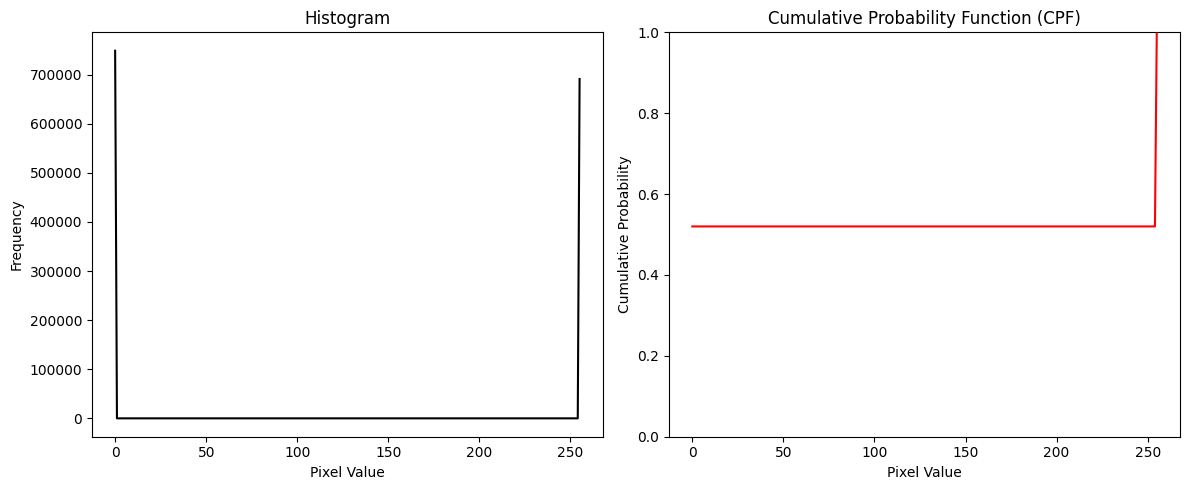

In [ ]:
# Compute the histogram
histogram, bins = np.histogram(image_array, bins=256, range=[0, 256])

# Compute the cumulative probability function (CPF)
cpf = histogram.cumsum() # Cumulative sum
cpf = cpf / cpf[-1]  # Normalize

# Plot the histogram and CPF
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogram plot
axes[0].plot(histogram, color='black')
axes[0].set_title("Histogram")
axes[0].set_xlabel("Pixel Value")
axes[0].set_ylabel("Frequency")

# CPF plot
axes[1].plot(cpf, color='red')
axes[1].set_title("Cumulative Probability Function (CPF)")
axes[1].set_xlabel("Pixel Value")
axes[1].set_ylabel("Cumulative Probability")
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# 2.3

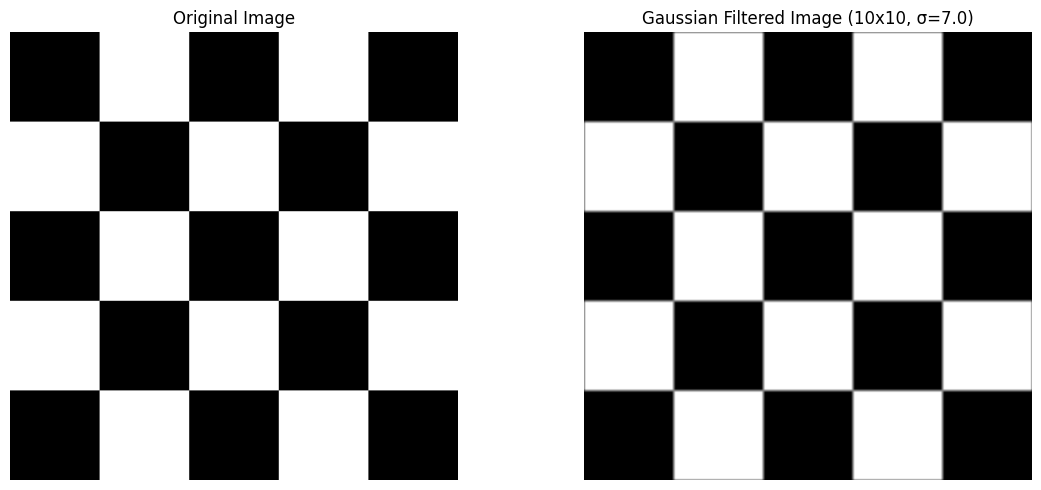

In [ ]:

# Ensure image pixels is in range [0,1] for consistent calculations
if image_array.max() > 1:
    image_array = image_array / 255.0

# Define a function for convolution
def convolve_image(image, kernel):
    kernel_height, kernel_width = kernel.shape
    image_height, image_width = image.shape
    padding_y = kernel_height // 2
    padding_x = kernel_width // 2

    # Add padding to the image borders (zero padding)
    padded_image = np.pad(image, ((padding_y, padding_y), (padding_x, padding_x)), mode='constant', constant_values=0)
    output_image = np.zeros_like(image)

    # Perform convolution
    for y in range(image_height):   # iterates through each row
        for x in range(image_width):    #iterates through each column
            region = padded_image[y:y+kernel_height, x:x+kernel_width]
            output_image[y, x] = np.sum(region * kernel)

    return output_image

# Function to create Gaussian kernel
def gaussian_kernel(size, sigma):
    kernel = np.zeros((size, size))
    center = size // 2
    for i in range(size):
        for j in range(size):
            x = i - center
            y = j - center
            kernel[i, j] = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    return kernel / np.sum(kernel)  # Normalize kernel

kernel_size = 10
sigma = 7.0

# Create Gaussian filter kernel
gaussian_filter = gaussian_kernel(kernel_size, sigma)

# Apply the Gaussian filter using convolution
smoothed_image = convolve_image(image_array, gaussian_filter)

# Normalize the output image to [0,1] and rescale to [0,255]
smoothed_image = (np.clip(smoothed_image, 0, 1) * 255).astype(np.uint8)

# Plot the original and smoothed images
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Original image
axes[0].imshow(image_array, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

# Gaussian filter smoothed image
axes[1].imshow(smoothed_image, cmap='gray')
axes[1].set_title(f"Gaussian Filtered Image ({kernel_size}x{kernel_size}, σ={sigma})")
axes[1].axis('off')

plt.tight_layout()
plt.show()

# 2.4
I chose the Gaussian filter and yes it can be seperable.<br>
A filter is separable if it can be decomposed into the product of 2 1D filters.<br>
for a Gaussian filter it can be represented as an equation as:<br><br>$w(i, j) = Ke ^{-\frac{i^2 + j^2}{2σ^2}}$<br><br>
we can change this to:<br><br>$Ke ^{-\frac{i^2}{2σ^2}}$ and $Ke ^{-\frac{i^2}{2σ^2}}$ (one for rows and one for columns)<br><br>
which are 2 1D filters

# 2.5

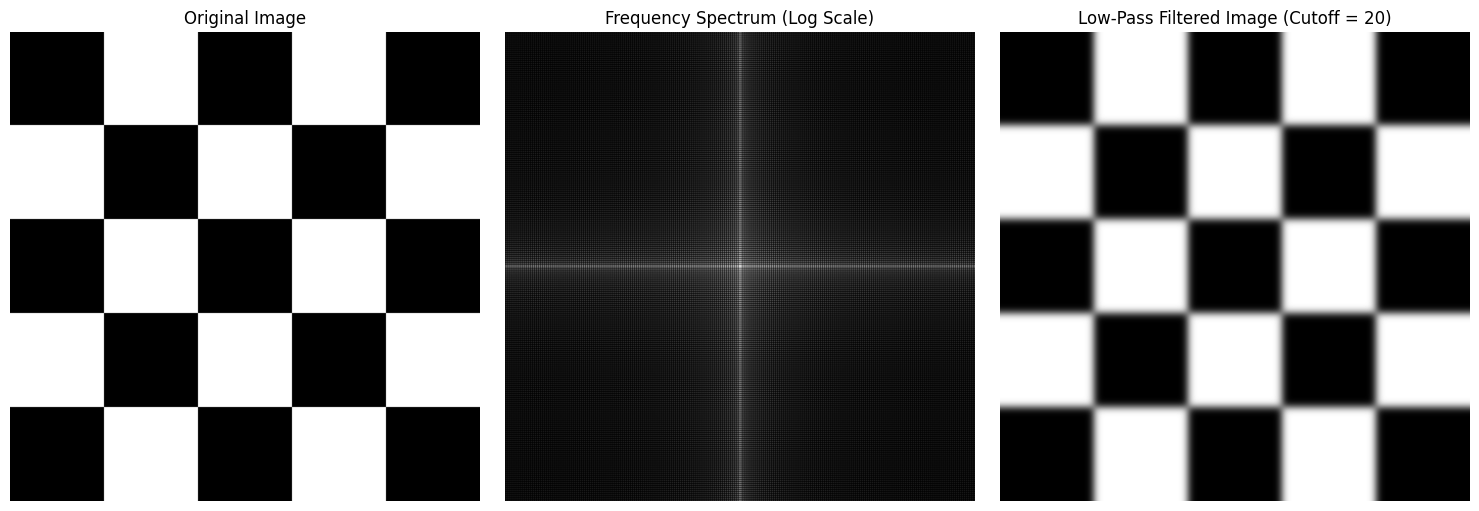

In [ ]:
# Get image dimensions
height, width = image_array.shape

# Perform Fourier Transform
f_transform = np.fft.fft2(image_array)
f_transform_shifted = np.fft.fftshift(f_transform)  # Shift zero-frequency to center

# Create a Gaussian Low-Pass Filter
def gaussian_lowpass_filter(shape, cutoff):
    h, w = shape
    y, x = np.ogrid[:h, :w]
    center_y, center_x = h // 2, w // 2
    distance = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    return np.exp(-(distance**2) / (2 * cutoff**2))  # Gaussian function

# Adjust cutoff frequency to control smoothing
cutoff_frequency = 20   # cuts off frequencies higher than 20

# Generate filter
lowpass_filter = gaussian_lowpass_filter((height, width), cutoff_frequency)

# Apply the filter in the frequency domain
filtered_f_transform = f_transform_shifted * lowpass_filter

# Perform Inverse FFT (converting back to spatial domain)
filtered_f_transform = np.fft.ifftshift(filtered_f_transform)  # Shift back
smoothed_image = np.fft.ifft2(filtered_f_transform).real  # Get real part

# Normalize the output image (ensuring value stay between 0 and 1)
smoothed_image = np.clip(smoothed_image, 0, 1)

# Plot original and smoothed images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original Image
axes[0].imshow(image_array, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

# Frequency Spectrum
axes[1].imshow(np.log1p(np.abs(f_transform_shifted)), cmap='gray')
axes[1].set_title("Frequency Spectrum (Log Scale)")
axes[1].axis('off')

# Smoothed Image
axes[2].imshow(smoothed_image, cmap='gray')
axes[2].set_title(f"Low-Pass Filtered Image (Cutoff = {cutoff_frequency})")
axes[2].axis('off')

plt.tight_layout()
plt.show()


# 2.6

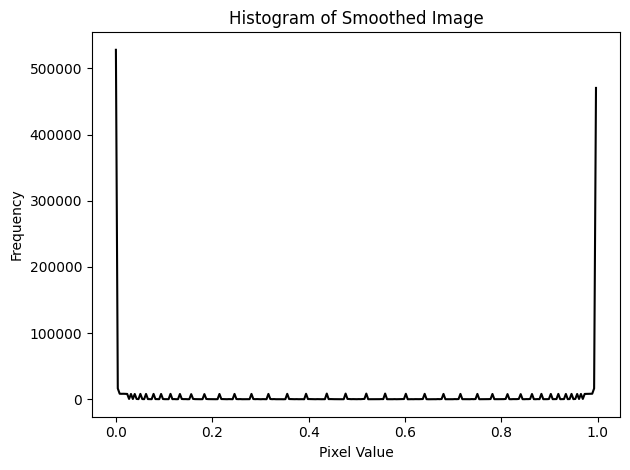

In [20]:
histogram, bins = np.histogram(smoothed_image, bins=256, range=[0, 1])

plt.plot(bins[:-1], histogram, color='black')
plt.title("Histogram of Smoothed Image")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


# 2.7

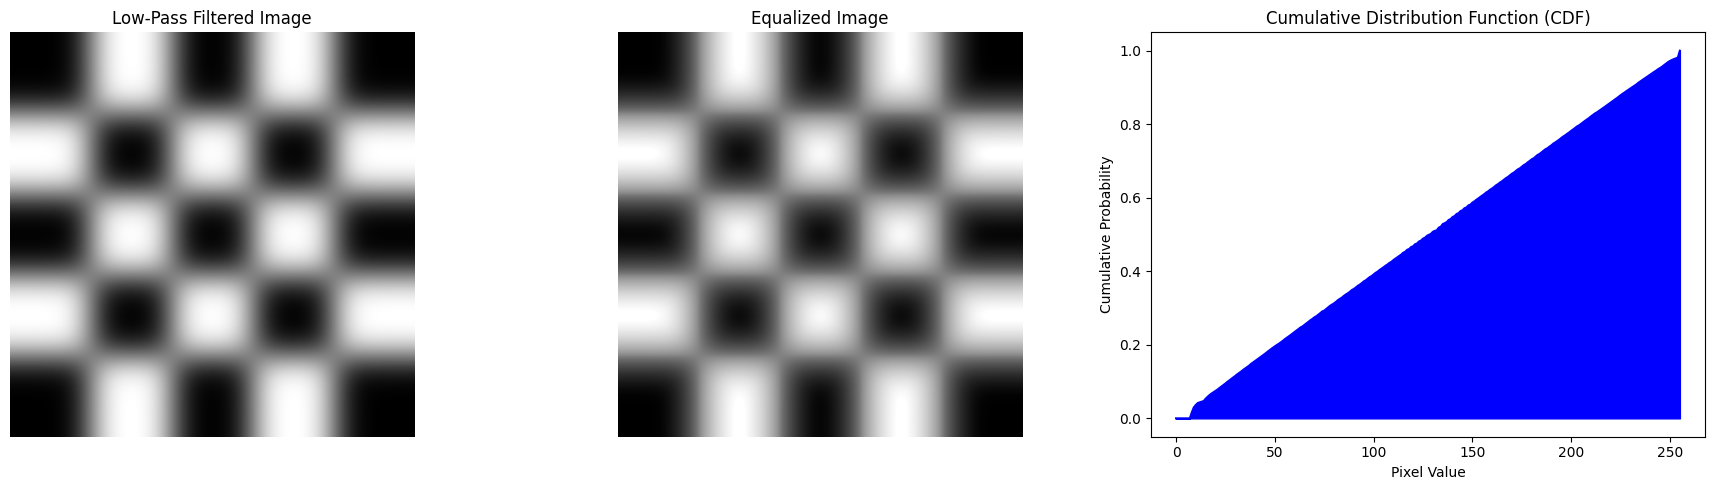

In [ ]:
# Adjust cutoff frequency to control smoothing
cutoff_frequency = 4

# Generate filter
lowpass_filter = gaussian_lowpass_filter((height, width), cutoff_frequency)

# Apply the filter in the frequency domain
filtered_f_transform = f_transform_shifted * lowpass_filter

# Perform Inverse FFT
filtered_f_transform = np.fft.ifftshift(filtered_f_transform)  # Shift back
smoothed_image = np.fft.ifft2(filtered_f_transform).real  # Get real part

# Normalize the output image
smoothed_image = np.clip(smoothed_image, 0, 1)

# Compute the histogram of the smoothed image
histogram, bins = np.histogram(smoothed_image, bins=256, range=[0, 1])

# Compute the CDF (Cumulative Distribution Function)
cdf = histogram.cumsum()  # Cumulative sum of the histogram
cdf_normalized = cdf / cdf[-1]  # Normalize the CDF to [0, 1]

# Map the pixel values to the new intensity values based on the CDF
equalized_image = np.interp(smoothed_image.flatten(), bins[:-1], cdf_normalized)
equalized_image = equalized_image.reshape(smoothed_image.shape)

histogram, bins = np.histogram(equalized_image, bins=256, range=[0, 1])

cdf = histogram.cumsum()  # Cumulative sum of the histogram
cdf_normalizeds = cdf / cdf[-1]  # Normalize the CDF to [0, 1]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot the original checkerboard image (smoothed)
axes[0].imshow(smoothed_image, cmap='gray')
axes[0].set_title("Low-Pass Filtered Image")
axes[0].axis('off')

# Plot the equalized image
axes[1].imshow(equalized_image, cmap='gray')
axes[1].set_title("Equalized Image")
axes[1].axis('off')

# Plot the CDF
axes[2].fill_between(range(len(cdf_normalizeds)), cdf_normalizeds, color='blue', alpha=1)
axes[2].plot(cdf_normalizeds, color='blue')
axes[2].set_title("Cumulative Distribution Function (CDF)")
axes[2].set_xlabel("Pixel Value")
axes[2].set_ylabel("Cumulative Probability")

plt.tight_layout()
plt.show()
